<a href="https://colab.research.google.com/github/hallpaz/nov23google/blob/main/code/representational_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representational Networks

## Hallison Paz

### November 8th, 2023

Lecture given at Google Brasil's office at São Paulo.

Additional resources available at [this repository](https://github.com/hallpaz/googlesptalk).



In [34]:
from IPython.display import HTML
HTML('''<iframe width="560" height="315"
        src="https://www.youtube.com/embed/_ZtQ0-tDwbY"
        frameborder="0" allow="accelerometer; autoplay; encrypted-media;
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Training a Representational Network for Images

In [1]:
import torch
from torch import nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
import imageio
import numpy as np
from typing import Sequence

# Defining a dataset structure

In [11]:
def make_grid_coords(nsamples, start, end, dim, flatten=True):
  if not isinstance(nsamples, Sequence):
      nsamples = dim * [nsamples]
  if not isinstance(start, Sequence):
      start = dim * [start]
  if not isinstance(end, Sequence):
      end = dim * [end]
  if len(nsamples) != dim or len(start) != dim or len(end) != dim:
      raise ValueError("'nsamples'; 'start'; and 'end' should be a single value or have same  length as 'dim'")

  dir_samples = tuple([torch.linspace(start[i], end[i], steps=nsamples[i])
                  for i in range(dim)])
  grid = torch.stack(torch.meshgrid(*dir_samples, indexing='ij'), dim=-1)
  return grid.reshape(-1, dim) if flatten else grid

class ImageDataset(Dataset):
  def __init__(self, filepath, size=0, color_space='L'):
    super().__init__()
    img = Image.open(filepath).convert(color_space)
    if size > 0:
      img = img.resize((size, size))
    else:
      size = img.width
    if color_space == 'L':
      self.channels = 1
    else:
      self.channels = 3
    # N x 2; N = width * height
    self.coords = make_grid_coords(size, -1, 1, 2)
    # N x (1 ou 3)
    self.pixels = to_tensor(img).permute(1, 2, 0).reshape(-1, self.channels)


  def __len__(self):
    #return len(self.pixels)
    return 1

  def __getitem__(self, index):
    return self.coords, self.pixels

def network_to_image(model, channels=3, res=512,
                     return_img=False, device='cpu'):
  coords = make_grid_coords(res, -1, 1, 2).to(device)
  pixels = model(coords).clamp(0, 1).reshape(res, res, channels)
  img = pixels.squeeze(-1).detach().cpu().numpy()
  if return_img:
    return img
  plt.imshow(img)

In [ ]:
# show dataset

# Training routine

In [14]:
def train(model, dataloader, hyper, device,
          steps_til_summary=100, gif_path=""):
    dim = hyper['width']
    epochs = hyper['epochs']
    channels = hyper['channels']
    model.to(device)
    model.train()
    optim = torch.optim.Adam(lr=1e-3, params=model.parameters())
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    if gif_path:
        writer = imageio.get_writer(gif_path, mode='I', duration=0.3)

    for step in range(epochs):
        model_output = model(model_input.to(device))
        loss = ((model_output - ground_truth)**2).mean()

        if not (step % steps_til_summary):
            print("Step %d, Total loss %0.6f" % (step, loss))
            # plot_tensor_img(model_output, dim)
            network_to_image(model, channels, dim, device=device)

        if gif_path and (step % 5 == 0):
            img = network_to_image(model, channels, dim, True, device)
            writer.append_data(np.uint8(img * 255))

        optim.zero_grad()
        loss.backward()
        optim.step()
    # last inference
    model.eval()
    network_to_image(model, hyper['channels'], return_img=True, device=device)
    if gif_path:
      writer.append_data(np.uint8(img * 255))
      writer.close()

# Defining a Neural Network model

In [4]:
class ReluNetwork(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(2, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, channels)
    )

  def forward(self, input):
    return self.layers(input)


In [5]:
hyper = {
    'width': 256,
    'height': 256,
    'channels': 3,
    'epochs': 1000
}

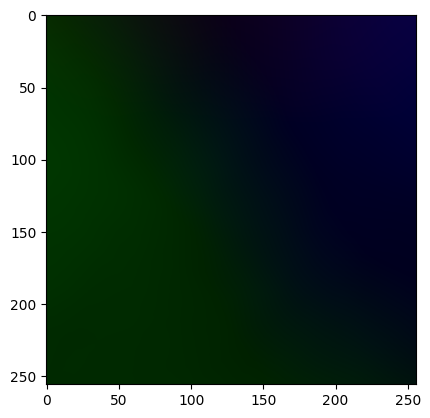

In [18]:
relu_model = ReluNetwork(3)
network_to_image(relu_model, 3, hyper['width'])

In [17]:
dataset = ImageDataset("/content/masp.jpg", hyper['width'], "RGB")
dataloader = DataLoader(dataset, hyper['width'] * hyper['width'])

Step 0, Total loss 0.152870
Step 10, Total loss 0.069330
Step 20, Total loss 0.060897
Step 30, Total loss 0.055490
Step 40, Total loss 0.052746
Step 50, Total loss 0.050304
Step 60, Total loss 0.048267
Step 70, Total loss 0.046358
Step 80, Total loss 0.044586
Step 90, Total loss 0.042911
Step 100, Total loss 0.041422
Step 110, Total loss 0.040051
Step 120, Total loss 0.038821
Step 130, Total loss 0.037809
Step 140, Total loss 0.036968
Step 150, Total loss 0.036265
Step 160, Total loss 0.035680
Step 170, Total loss 0.035154
Step 180, Total loss 0.034688
Step 190, Total loss 0.034276
Step 200, Total loss 0.033882
Step 210, Total loss 0.033524
Step 220, Total loss 0.033350
Step 230, Total loss 0.032882
Step 240, Total loss 0.032563
Step 250, Total loss 0.032296
Step 260, Total loss 0.032024
Step 270, Total loss 0.032193
Step 280, Total loss 0.031688
Step 290, Total loss 0.031387
Step 300, Total loss 0.031110
Step 310, Total loss 0.030894
Step 320, Total loss 0.030908
Step 330, Total loss 

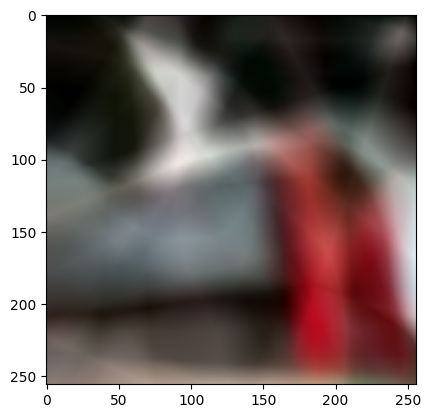

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train(relu_model, dataloader, hyper,
      device,
      steps_til_summary=10,
      gif_path='masp.gif')

In [20]:
class FourierNetwork(nn.Module):
  def __init__(self, omega_0=30, channels=1):
    super().__init__()
    self.omega_0 = omega_0
    self.first_layer = nn.Linear(2, 256)
    self.layers = nn.Sequential(
        nn.Linear(256, 256),
        nn.ReLU(),
        # nn.Linear(256, 256),
        # nn.ReLU(),
        nn.Linear(256, channels)
    )

    with torch.no_grad():
      self.first_layer.weight.uniform_(-1 / 2, 1 / 2)

  def forward(self, coords):
    x = torch.sin(self.omega_0 * self.first_layer(coords))
    return self.layers(x)

Step 0, Total loss 0.172440
Step 10, Total loss 0.037334
Step 20, Total loss 0.024694
Step 30, Total loss 0.021337
Step 40, Total loss 0.019712
Step 50, Total loss 0.018782
Step 60, Total loss 0.018193
Step 70, Total loss 0.017739
Step 80, Total loss 0.017362
Step 90, Total loss 0.017037
Step 100, Total loss 0.016748
Step 110, Total loss 0.016487
Step 120, Total loss 0.016244
Step 130, Total loss 0.016016
Step 140, Total loss 0.015801
Step 150, Total loss 0.015597
Step 160, Total loss 0.015404
Step 170, Total loss 0.015220
Step 180, Total loss 0.015043
Step 190, Total loss 0.014874
Step 200, Total loss 0.014711
Step 210, Total loss 0.014552
Step 220, Total loss 0.014399
Step 230, Total loss 0.014249
Step 240, Total loss 0.014104
Step 250, Total loss 0.013961
Step 260, Total loss 0.013822
Step 270, Total loss 0.013686
Step 280, Total loss 0.013553
Step 290, Total loss 0.013423
Step 300, Total loss 0.013296
Step 310, Total loss 0.013172
Step 320, Total loss 0.013052
Step 330, Total loss 

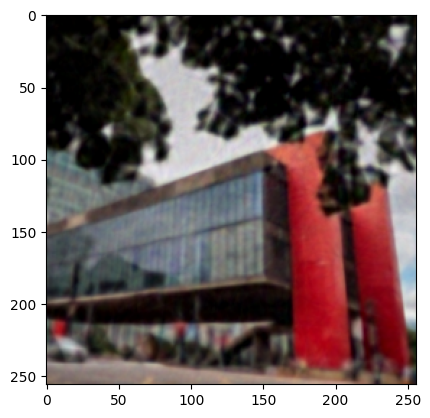

In [21]:
fourier_model = FourierNetwork(30, 3)
train(fourier_model,
      dataloader,
      hyper,
      device,
      steps_til_summary=10,
      gif_path='fourier_masp.gif')

In [22]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        # return output, coords
        return output

Step 0, Total loss 0.157016
Step 10, Total loss 0.025465
Step 20, Total loss 0.012664
Step 30, Total loss 0.008562
Step 40, Total loss 0.006593
Step 50, Total loss 0.005427
Step 60, Total loss 0.004797
Step 70, Total loss 0.003987
Step 80, Total loss 0.003486
Step 90, Total loss 0.003230
Step 100, Total loss 0.002791
Step 110, Total loss 0.002542
Step 120, Total loss 0.002283
Step 130, Total loss 0.002081
Step 140, Total loss 0.001862
Step 150, Total loss 0.001753
Step 160, Total loss 0.001630
Step 170, Total loss 0.001418
Step 180, Total loss 0.001360
Step 190, Total loss 0.001332
Step 200, Total loss 0.001177
Step 210, Total loss 0.001115
Step 220, Total loss 0.001008
Step 230, Total loss 0.001031
Step 240, Total loss 0.000982
Step 250, Total loss 0.000846
Step 260, Total loss 0.000946
Step 270, Total loss 0.000816
Step 280, Total loss 0.000740
Step 290, Total loss 0.000859
Step 300, Total loss 0.000701
Step 310, Total loss 0.000706
Step 320, Total loss 0.000780
Step 330, Total loss 

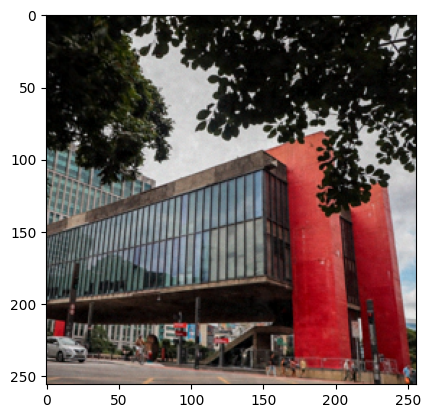

In [33]:
siren_model = Siren(2, 256, 2, 3, True, 30)
train(siren_model,
      dataloader,
      hyper,
      device,
      steps_til_summary=10,
      gif_path='siren_masp.gif')

# Exploring the model's space continuity

In [25]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, Box, interact_manual

In [26]:
slider = widgets.FloatRangeSlider(
    value=[-1.0, 1.0],
    min=-7,
    max=7,
    step=0.1,
    description='Interval:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='50%')
)

In [32]:
model = siren_model
res = hyper['width']
channels = hyper['channels']
def plot_model(interval):
  # interval_length = abs(interval[0] - interval(1))
  # width = min(2, )
  model.to(device)
  grid = make_grid_coords(res, *interval, dim=2).to(device)
  output = model(grid)
  # model_out = torch.clamp(output['model_out'], 0.0, 1.0)
  model_out = torch.clamp(output, 0.0, 1.0)

  pixels = model_out.cpu().detach().view(res, res, channels).cpu()
  pixels = (pixels * 255).numpy().astype(np.uint8)
  if channels == 1:
      pixels = np.repeat(pixels, 3, axis=-1)
  return Image.fromarray(pixels)

interact(plot_model, interval=slider)

interactive(children=(FloatRangeSlider(value=(-1.1, 1.0), continuous_update=False, description='Interval:', la…

<function __main__.plot_model(interval)>